In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn joblib

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import joblib

# Define the path to the Excel file

file_path = r"Prediction_Data.xlsx"


# Define the sheet name to read data from
sheet_name = 'vw_ChurnData'


# Read the data from the specified sheet into a pandas DataFrame
data = pd.read_excel(file_path, sheet_name=sheet_name)


# Display the first few rows of the fetched data
print(data.head())

  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   12505-GUJ    Male   29      No      Gujarat                    0   
1   12510-MAH    Male   44     Yes  Maharashtra                   14   
2   12511-DEL    Male   50     Yes        Delhi                    2   
3   12513-MAH  Female   18      No  Maharashtra                    3   
4   12516-TAM  Female   25     Yes   Tamil Nadu                    3   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7        NaN           Yes             No  ...   
1                33     Deal 1           Yes            Yes  ...   
2                18        NaN           Yes            Yes  ...   
3                 3        NaN           Yes            Yes  ...   
4                30     Deal 3           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal      95.650002    167.300003           0.0   
1  Bank Withdrawal     112.2

In [10]:
# Drop columns that won't be used for prediction
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

# List of columns to be label encoded
columns_to_encode = [ 'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
                   'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
                   'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
                   'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 'Payment_Method']


# Encode categorical variables except the target variable
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])


# Manually encode the target variable 'Customer_Status'
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

# Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Confusion Matrix:
[[794  53]
 [126 229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       847
           1       0.81      0.65      0.72       355

    accuracy                           0.85      1202
   macro avg       0.84      0.79      0.81      1202
weighted avg       0.85      0.85      0.85      1202



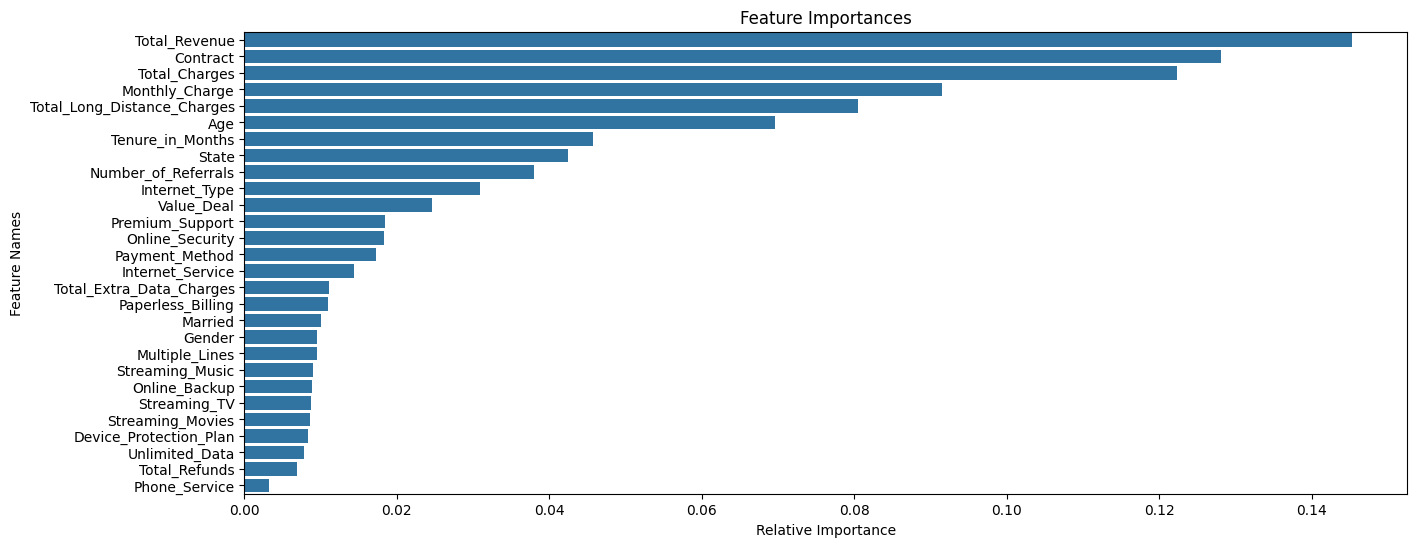

In [12]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

In [13]:
# Define the path to the Joiner Data Excel file
file_path = r"Prediction_Data.xlsx"

# Define the sheet name to read data from
sheet_name = 'vw_JoinData'



# Read the data from the specified sheet into a pandas DataFrame
new_data = pd.read_excel(file_path, sheet_name=sheet_name)


# Display the first few rows of the fetched data
print(new_data.head())

# Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy()


# Retain the Customer_ID column
customer_ids = new_data['Customer_ID']

# Drop columns that won't be used for prediction in the encoded DataFrame
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)



# Encode categorical variables using the saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])



# Make predictions
new_predictions = rf_model.predict(new_data)

# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions


# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   12490-TEL  Female   52      No    Telangana                    9   
1   14567-TAM    Male   43      No   Tamil Nadu                    1   
2   21165-DEL  Female   38      No        Delhi                    2   
3   21247-ASS    Male   58     Yes        Assam                    2   
4   21288-MAH  Female   63      No  Maharashtra                   12   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 6        NaN           Yes             No  ...   
1                 9        NaN           Yes             No  ...   
2                32     Deal 5           Yes             No  ...   
3                 2        NaN           Yes             No  ...   
4                34        NaN           Yes            Yes  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      74.750000    238.100006         38.84   
1      Credit Card      20.3

In [14]:
original_data.to_csv(r"Predictions.csv", index=False)